In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import date

In [2]:
from sklearn import preprocessing


In [3]:
import seaborn as sns

In [4]:
from sklearn.model_selection import KFold

In [5]:
from sklearn.metrics import mean_absolute_error

In [6]:
from sklearn.metrics import mean_squared_error

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
# Load Train Data
train = pd.read_csv('../data/processed/train_norm.csv', sep=';')

In [10]:
train.shape

(34183, 95)

In [11]:
train['fecha_venta_norm'] = pd.to_datetime(train['fecha_venta_norm'])

In [12]:
train['fecha_venta_norm'] = train['fecha_venta_norm'].dt.date

In [13]:
train['year'] = pd.to_datetime(train.fecha_venta_norm).dt.year
train['month'] = pd.to_datetime(train.fecha_venta_norm).dt.month

In [14]:
train.fecha_venta_norm.unique()

array([datetime.date(2013, 12, 1), datetime.date(2013, 11, 1),
       datetime.date(2012, 12, 1), datetime.date(2012, 11, 1),
       datetime.date(2014, 11, 1), datetime.date(2014, 10, 1),
       datetime.date(2013, 10, 1), datetime.date(2014, 9, 1),
       datetime.date(2013, 9, 1), datetime.date(2013, 7, 1),
       datetime.date(2013, 6, 1), datetime.date(2013, 8, 1)], dtype=object)

In [ ]:
# Filtramos los meses que consideramos buenos para el entrenamiento (11 y 12)
train = train[train.fecha_venta_norm.isin([     date(2012, 11, 1),
                                                date(2012, 12, 1),
                                                date(2013, 11, 1), 
                                                date(2013, 12, 1), 
                                                date(2014, 11, 1)
])]

In [15]:
train.shape

(34183, 95)

In [16]:
predictors = ['id_pos',
              'unidades', 'canal', 'competidores',
       'ingreso_mediana', 'densidad_poblacional',
       'pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf', 'pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar']

In [17]:
X = train[predictors].copy()

In [18]:
y = train['unidades']

In [19]:
X.drop('unidades', inplace=True, axis=1)

In [20]:
# fill Nans
for c in X.columns[X.dtypes != 'object']:
    X[c].fillna(X[c].median(), inplace=True)

In [21]:
X.columns[X.dtypes == 'object']

Index(['canal'], dtype='object')

In [22]:
# Dummy
canal_dummy = pd.get_dummies(X['canal'])

In [23]:
X = pd.merge(X, canal_dummy, how='inner', left_index=True, right_index=True)

In [24]:
X.drop('canal', axis=1, inplace=True)

In [26]:
predictors = ['id_pos','competidores',
       'ingreso_mediana', 'densidad_poblacional',
       'pct_0a5', 'pct_5a9', 'pct_10a14', 'pct_15a19', 'pct_20a24',
       'pct_25a29', 'pct_30a34', 'pct_35a39', 'pct_40a44', 'pct_45a49',
       'pct_50a54', 'pct_55a59', 'pct_60a64', 'pct_65a69', 'pct_70a74',
       'pct_75a79', 'pct_80a84', 'pct_85ainf', 'pct_bachelors',
       'pct_doctorados', 'pct_secundario', 'pct_master', 'pct_bicicleta',
       'pct_omnibus', 'pct_subtes', 'pct_taxi', 'pct_caminata',
       'mediana_valor_hogar', 'ALMACEN', 'MAXIKIOSCO', 
             # 'PARTICULARES', 
              'SUPERMERCADOS'
             ]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X[predictors], y, test_size=0.2, random_state=47)

In [29]:
y_train.describe()

count    14912.000000
mean        27.593884
std         24.872706
min          1.000000
25%         10.000000
50%         19.000000
75%         40.000000
max        252.000000
Name: unidades, dtype: float64

In [30]:
# definimos los extremos de los valores con los correspondiente a Q1 y Q3
y_train = y_train.clip(10,40)

In [31]:
ridge = Ridge()

In [32]:
parameters = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1-2, 1, 2, 5, 
                        8, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 200]}

In [33]:
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_absolute_error', cv=5, n_jobs=5)

In [34]:
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, -1, 1, 2, 5, 8, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 200]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [35]:
print(ridge_regressor.best_params_)

{'alpha': -1}


In [36]:
print(ridge_regressor.best_score_)

-9.262515803521039


In [37]:
ridge = Ridge(alpha=-1)

In [38]:
ridge.fit(X_train, y_train)

Ridge(alpha=-1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [39]:
y_pred = ridge.predict(X_test)

In [40]:
y_pred = np.where(y_pred < 0, 0, y_pred)

In [41]:
print("MAE test: ", mean_absolute_error(y_test, y_pred))

MAE test:  16.15204320022992


#### Linear Regressor

In [53]:
lr = LinearRegression(n_jobs=4)

In [54]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=4, normalize=False)

In [55]:
y_pred = lr.predict(X_test)

In [56]:
y_pred = np.where(y_pred < 0, 0, y_pred)

In [57]:
print("MAE test: ", mean_absolute_error(y_test, y_pred))

MAE test:  13.225827723459657


In [58]:
import matplotlib.pyplot as plt


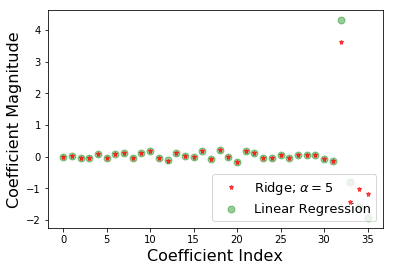

In [59]:
plt.plot(ridge.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 5$',zorder=7) # zorder for ordering the markers
#plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [60]:
for i,j in zip(X.columns.values,ridge.coef_):
    print(i,' : ', j)
    

id_pos  :  -0.0003859544562712099
competidores  :  0.029214978767656254
ingreso_mediana  :  -0.0320530847566847
densidad_poblacional  :  -0.05095643563449879
pct_0a5  :  0.06856344147633607
pct_5a9  :  -0.040230155596428126
pct_10a14  :  0.08464462970581556
pct_15a19  :  0.10872604684860045
pct_20a24  :  -0.03651785633544277
pct_25a29  :  0.12886944276688228
pct_30a34  :  0.16675626628914567
pct_35a39  :  -0.037323665486772475
pct_40a44  :  -0.12137805574843734
pct_45a49  :  0.10521614453229061
pct_50a54  :  0.007215036692337295
pct_55a59  :  -0.009136119574190705
pct_60a64  :  0.18309835648857836
pct_65a69  :  -0.060801569827966855
pct_70a74  :  0.21791152620786255
pct_75a79  :  -0.00767495625769693
pct_80a84  :  -0.1822365221036048
pct_85ainf  :  0.16443221074945188
pct_bachelors  :  0.1312450360509957
pct_doctorados  :  -0.032422383358535825
pct_secundario  :  -0.043091288021544306
pct_master  :  0.05775033931576997
pct_bicicleta  :  -0.028767718858950603
pct_omnibus  :  0.047253093